# **Heart Disease Classification**

This notebook aims to predict if a person has heart disease by using various features like Age, Smoking condition, No of cigarettes smoken etc.
We will understand the data, pre-process it and model using some classification models like Logistic Regression, K-NN, SVM and evaluate the performance among different models. 

Firstly, we'll import the required libraries

## **Required Libraries**

In [531]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

import kagglehub
from kagglehub import KaggleDatasetAdapter
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from prettytable import PrettyTable


## **Read the data**

Before you download the data, make sure you run the following commands in your terminal.

1. Create a Kaggle API token.

   Navigate to settings in kaggle > Create New Token.

   This will download a Kaggle.json file in downloads.

2. Now run command, **mkdir -p ~/.kaggle**

   This ensures that a hidden folder called .kaggle exists in your home directory

3. Next run, **mv ~/Downloads/kaggle.json ~/.kaggle/**

   This movies the API credentials file into the .kaggle folder

4. Finally run, **chmod 600 ~/.kaggle/kaggle.json**

   This command makes sure that kaggle credentials are private and secure. Without this step CLI might refuse to use the file because of 'insecure permissions'

The data used is from https://www.kaggle.com/datasets/dileep070/heart-disease-prediction-using-logistic-regression.

It is from an ongoing cardiovascular study on residents of the town of Framingham, Massachusetts. The goal is to predict whether the patient has 10-year risk of future coronary heart disease (CHD). Refer to the next section for more details on the data.

In [325]:
!kaggle datasets download dileep070/heart-disease-prediction-using-logistic-regression --unzip --force -p ./data

Dataset URL: https://www.kaggle.com/datasets/dileep070/heart-disease-prediction-using-logistic-regression
License(s): unknown
  0%|                                               | 0.00/58.4k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 58.4k/58.4k [00:00<00:00, 38.2MB/s]


In [326]:
data_dir = './data'
files = os.listdir('./data')

print(f'Number of files: {len(files)} \n')

print('Files:')

for file in files:
    print(os.path.join(data_dir, file))

Number of files: 1 

Files:
./data/framingham.csv


In [327]:
heart_data = pd.read_csv(os.path.join(data_dir, files[0]))

The below command reads the framingham.csv file directly from kaggle using kagglehub library.

The only catch is that, the file name has to input correctly like framingham.csv

Run either the cell above or cell below to get the data.

In [328]:
heart_data = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    'dileep070/heart-disease-prediction-using-logistic-regression',
    'framingham.csv'
)

## **Data Exploration**

In [329]:
heart_data.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


The data contains the following features.

**Continuous Training Features:**

1. Age

2. CigsPerDay

3. TotChol

4. SysBP

5. DiaBP

6. BMI

7. HeartRate

8. Glucose


**Discrete Training Features:**

1. Male

2. Education

3. CurrentSmoker

4. BPMeds

5. PrevalentStroke

6. PrevalentHyp

7. Diabetes


**Target Variable:**

1. TenYearCHD

   


In [330]:
heart_data.describe().T

,count,mean,std,min,25%,50%,75%,max
male,4238.0,0.429212,0.495022,0.00,0.00,0.0,1.000,1.0
age,4238.0,49.584946,8.572160,32.00,42.00,49.0,56.000,70.0
education,4133.0,1.978950,1.019791,1.00,1.00,2.0,3.000,4.0
currentSmoker,4238.0,0.494101,0.500024,0.00,0.00,0.0,1.000,1.0
cigsPerDay,4209.0,9.003089,11.920094,0.00,0.00,0.0,20.000,70.0
BPMeds,4185.0,0.029630,0.169584,0.00,0.00,0.0,0.000,1.0
prevalentStroke,4238.0,0.005899,0.076587,0.00,0.00,0.0,0.000,1.0
prevalentHyp,4238.0,0.310524,0.462763,0.00,0.00,0.0,1.000,1.0
diabetes,4238.0,0.025720,0.158316,0.00,0.00,0.0,0.000,1.0
totChol,4188.0,236.721585,44.590334,107.00,206.00,234.0,263.000,696.0


In [331]:
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB


In [332]:
heart_data.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

### **Check for class imbalance**

In [333]:
heart_data.TenYearCHD.value_counts()

TenYearCHD
0    3594
1     644
Name: count, dtype: int64

As seen from the cell output above, the data distribution is imbalanced. 

About 15% of the data belongs to class 1 and the rest belongs to class 0.

Some of the common methods to handle this type of data imbalance are

1. Use **class_weights = 'balanced'** while invoking Logistic Regression class

2. Resampling

   Either **undersampling** or **oversampling**

3. Adjust classification threshold accordingly. Instead of choosing 0.5 as the default value, choose a threshold that balances precision and recall

## **Data Pre-processing**

### **Remove duplicates**

In [334]:
print(f'Number of records before removing duplicates: {len(heart_data)}')

Number of records before removing duplicates: 4238


In [335]:
data_df = heart_data.drop_duplicates()

In [336]:
print(f'Number of records after removing duplicates: {len(data_df)}')

Number of records after removing duplicates: 4238


There are no duplicates in the data as seen from the results above

### **Check for missing values**

In [337]:
missing_values_per_column = data_df.isnull().sum()/len(data_df) * 100

total_missing_values = missing_values_per_column.sum()/data_df.size * 100

print(f'Missing values per column (%): \n{missing_values_per_column} \n')

print(f'Total missing values (%): {total_missing_values:.2f}% \n')

Missing values per column (%): 
male               0.000000
age                0.000000
education          2.477584
currentSmoker      0.000000
cigsPerDay         0.684285
BPMeds             1.250590
prevalentStroke    0.000000
prevalentHyp       0.000000
diabetes           0.000000
totChol            1.179802
sysBP              0.000000
diaBP              0.000000
BMI                0.448325
heartRate          0.023596
glucose            9.155262
TenYearCHD         0.000000
dtype: float64 

Total missing values (%): 0.02% 



The missing values are handled after the train-test split to ensure that the model shouldn't have an idea of test data before training!!

So the missing value is handled in section 'Handling missing values' later on.

### **Check for normality**

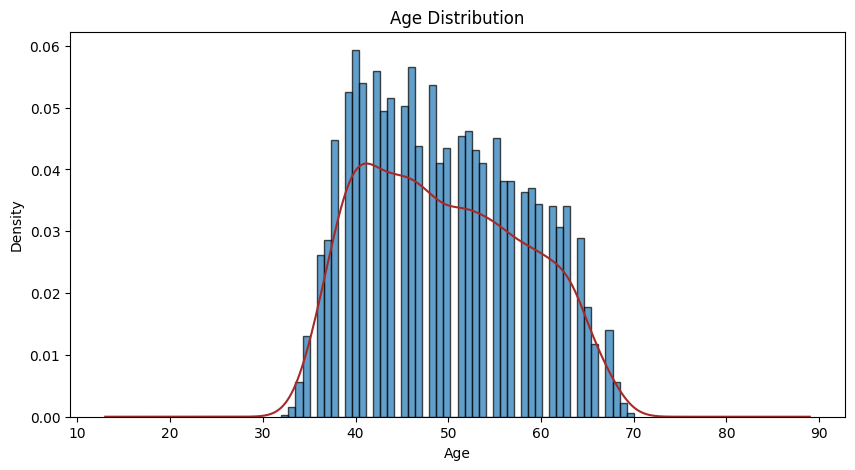

In [338]:
fig, ax = plt.subplots(figsize = (10,5))
data_df['age'].plot(kind = 'hist', bins = 50, ax = ax, edgecolor = 'black', alpha = 0.7, density = True)
data_df['age'].plot(kind = 'kde', ax = ax, color = 'brown')
ax.set_xlabel('Age')
ax.set_ylabel('Density')
ax.set_title('Age Distribution')
plt.show()

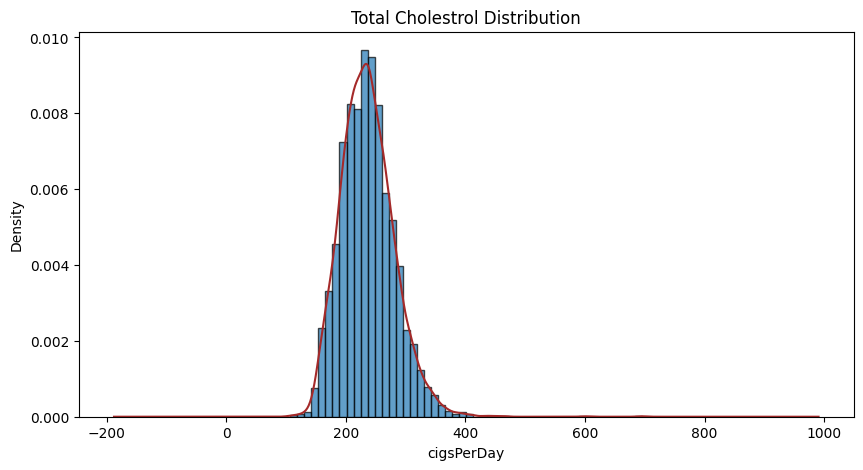

In [339]:
fig, ax = plt.subplots(figsize = (10,5))
data_df['totChol'].plot(kind = 'hist', bins = 50, ax = ax, edgecolor = 'black', alpha = 0.7, density = True)
data_df['totChol'].plot(kind = 'kde', ax = ax, color = 'brown')
ax.set_xlabel('cigsPerDay')
ax.set_ylabel('Density')
ax.set_title('Total Cholestrol Distribution')
plt.show()

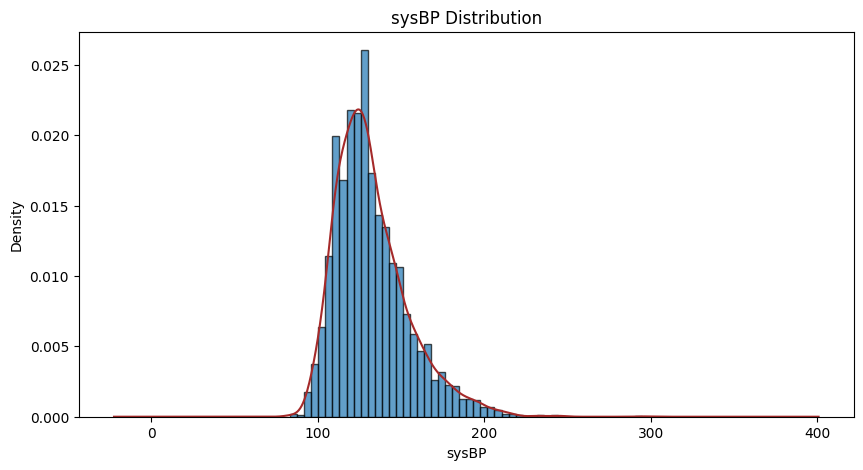

In [340]:
fig, ax = plt.subplots(figsize = (10,5))
data_df['sysBP'].plot(kind = 'hist', bins = 50, ax = ax, edgecolor = 'black', alpha = 0.7, density = True)
data_df['sysBP'].plot(kind = 'kde', ax = ax, color = 'brown')
ax.set_xlabel('sysBP')
ax.set_ylabel('Density')
ax.set_title('sysBP Distribution')
plt.show()

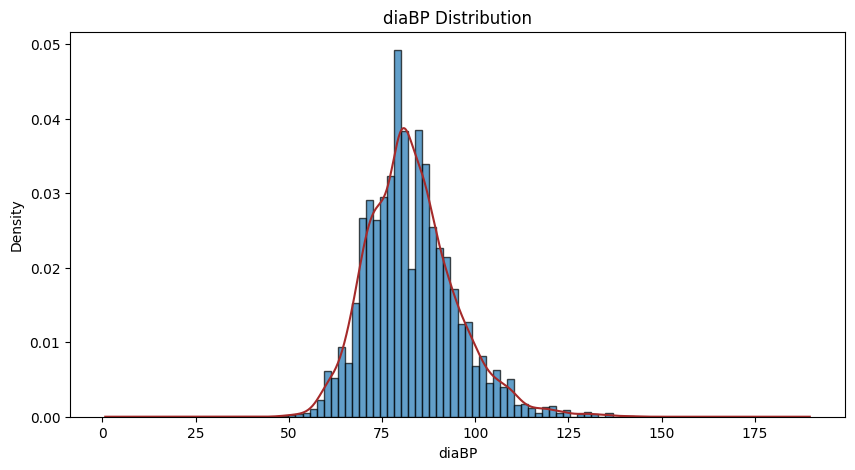

In [341]:
fig, ax = plt.subplots(figsize = (10,5))
data_df['diaBP'].plot(kind = 'hist', bins = 50, ax = ax, edgecolor = 'black', alpha = 0.7, density = True)
data_df['diaBP'].plot(kind = 'kde', ax = ax, color = 'brown')
ax.set_xlabel('diaBP')
ax.set_ylabel('Density')
ax.set_title('diaBP Distribution')
plt.show()

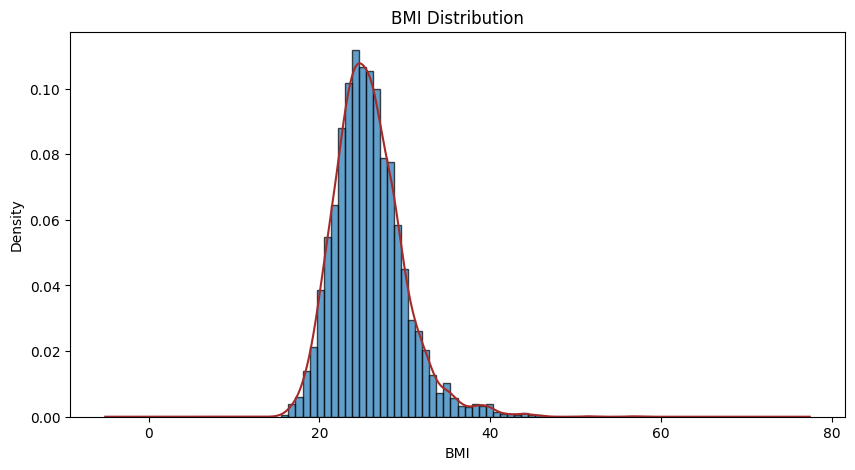

In [342]:
fig, ax = plt.subplots(figsize = (10,5))
data_df['BMI'].plot(kind = 'hist', bins = 50, ax = ax, edgecolor = 'black', alpha = 0.7, density = True)
data_df['BMI'].plot(kind = 'kde', ax = ax, color = 'brown')
ax.set_xlabel('BMI')
ax.set_ylabel('Density')
ax.set_title('BMI Distribution')
plt.show()

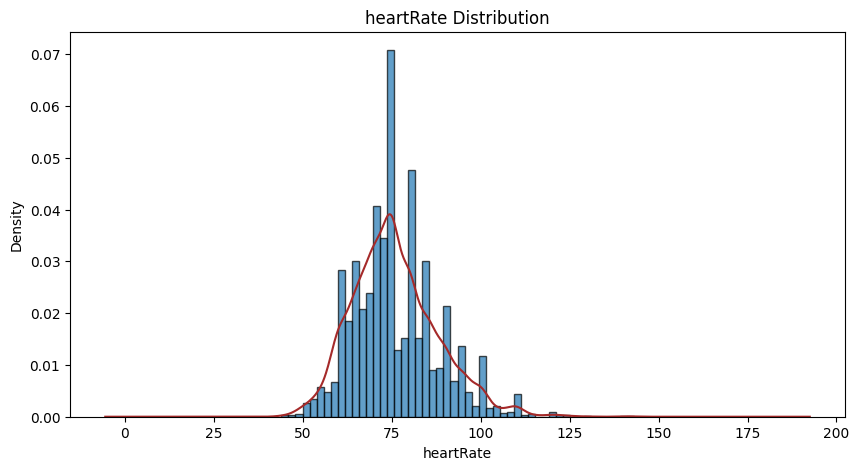

In [343]:
fig, ax = plt.subplots(figsize = (10,5))
data_df['heartRate'].plot(kind = 'hist', bins = 50, ax = ax, edgecolor = 'black', alpha = 0.7, density = True)
data_df['heartRate'].plot(kind = 'kde', ax = ax, color = 'brown')
ax.set_xlabel('heartRate')
ax.set_ylabel('Density')
ax.set_title('heartRate Distribution')
plt.show()

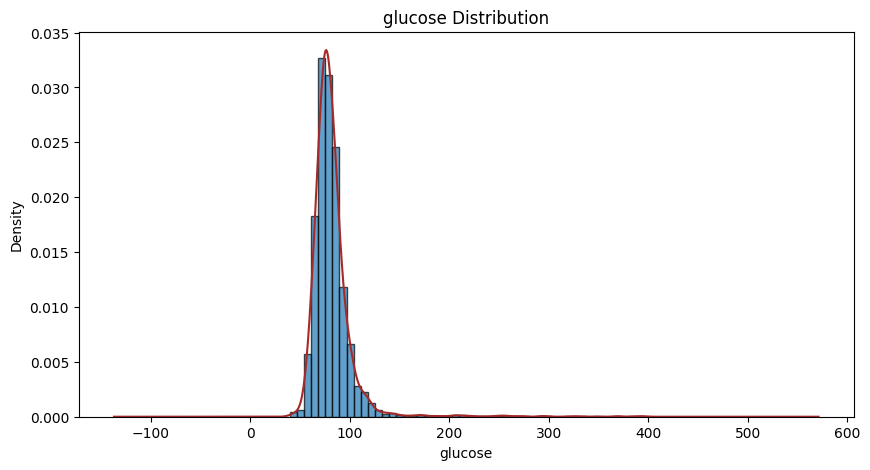

In [344]:
fig, ax = plt.subplots(figsize = (10,5))
data_df['glucose'].plot(kind = 'hist', bins = 50, ax = ax, edgecolor = 'black', alpha = 0.7, density = True)
data_df['glucose'].plot(kind = 'kde', ax = ax, color = 'brown')
ax.set_xlabel('glucose')
ax.set_ylabel('Density')
ax.set_title('glucose Distribution')
plt.show()

The check for normal distributions is done to make sure that the data is normally distributed and also to check and remove outliers.

For ex: The IQR method is non-parametric, meaning it doesn't make assumption about the data distribution. On the other hand, the Z score method is parametric. So the choice of IQR and Z-score method is chosen based upon the daa distribution. 

In our case, since the data is normally distributed, we'll proceed with the Z-score method. 

Also, in case the data isn't normally distributed, feature transformation shall be applied like sqrt(x), log(x) to make it normally distributed.

### **Check for outliers**

So as discussed above we tend to use Z-score method to eliminate the outliers for continuous variables and frequency distribution (value_counts) for discrete variables.

In [345]:
zscore_age = stats.zscore(data_df['age'].dropna())
outliers_age = data_df[np.abs(zscore_age) > 3]

print(f"Outliers in 'age' column using Z-score:\n{outliers_age.head(10)}\n")
print(f"Number of outliers in 'age' column using Z-score: {len(outliers_age)}")
print(f"Percentage of outliers in 'age' column using Z-score: {len(outliers_age) / len(data_df) * 100:.2f}%\n")

Outliers in 'age' column using Z-score:
Empty DataFrame
Columns: [male, age, education, currentSmoker, cigsPerDay, BPMeds, prevalentStroke, prevalentHyp, diabetes, totChol, sysBP, diaBP, BMI, heartRate, glucose, TenYearCHD]
Index: []

Number of outliers in 'age' column using Z-score: 0
Percentage of outliers in 'age' column using Z-score: 0.00%



In [346]:
zscore_cpd = stats.zscore(data_df['cigsPerDay'])
outliers_cpd = data_df[np.abs(zscore_cpd) > 3]

print(f"Outliers in 'cigsPerDay' column using Z-score:\n{outliers_cpd.head(10)}\n")
print(f"Number of outliers in 'cigsPerDay' column using Z-score: {len(outliers_cpd)}")
print(f"Percentage of outliers in 'cigsPerDay' column using Z-score: {len(outliers_cpd) / len(data_df) * 100:.2f}%\n")

Outliers in 'cigsPerDay' column using Z-score:
Empty DataFrame
Columns: [male, age, education, currentSmoker, cigsPerDay, BPMeds, prevalentStroke, prevalentHyp, diabetes, totChol, sysBP, diaBP, BMI, heartRate, glucose, TenYearCHD]
Index: []

Number of outliers in 'cigsPerDay' column using Z-score: 0
Percentage of outliers in 'cigsPerDay' column using Z-score: 0.00%



In [347]:
zscore_tcho = stats.zscore(data_df['totChol'])
outliers_tcho = data_df[np.abs(zscore_tcho) > 3]

print(f"Outliers in 'totChol' column using Z-score:\n{outliers_tcho.head(10)}\n")
print(f"Number of outliers in 'totChol' column using Z-score: {len(outliers_tcho)}")
print(f"Percentage of outliers in 'totChol' column using Z-score: {len(outliers_tcho) / len(data_df) * 100:.2f}%\n")

Outliers in 'totChol' column using Z-score:
Empty DataFrame
Columns: [male, age, education, currentSmoker, cigsPerDay, BPMeds, prevalentStroke, prevalentHyp, diabetes, totChol, sysBP, diaBP, BMI, heartRate, glucose, TenYearCHD]
Index: []

Number of outliers in 'totChol' column using Z-score: 0
Percentage of outliers in 'totChol' column using Z-score: 0.00%



In [348]:
zscore_sbp = stats.zscore(data_df['sysBP'])
outliers_sbp = data_df[np.abs(zscore_sbp) > 3]

print(f"Outliers in 'sysBP' column using Z-score:\n{outliers_sbp.head(10)}\n")
print(f"Number of outliers in 'sysBP' column using Z-score: {len(outliers_sbp)}")
print(f"Percentage of outliers in 'sysBP' column using Z-score: {len(outliers_sbp) / len(data_df) * 100:.2f}%\n")

Outliers in 'sysBP' column using Z-score:
     male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
44      0   53        3.0              0         0.0     1.0                0   
87      0   61        2.0              1         1.0     0.0                0   
153     0   66        1.0              0         0.0     0.0                0   
249     0   60        1.0              1        20.0     0.0                0   
333     0   55        2.0              0         0.0     1.0                0   
369     0   67        1.0              0         0.0     0.0                0   
446     1   61        1.0              0         0.0     0.0                0   
481     0   64        1.0              0         0.0     0.0                0   
590     0   60        2.0              1        20.0     1.0                0   
664     0   62        1.0              0         0.0     0.0                0   

     prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRa

In [349]:
zscore_dbp = stats.zscore(data_df['diaBP'])
outliers_dbp = data_df[np.abs(zscore_dbp) > 3]

print(f"Outliers in 'diaBP' column using Z-score:\n{outliers_dbp.head(10)}\n")
print(f"Number of outliers in 'diaBP' column using Z-score: {len(outliers_dbp)}")
print(f"Percentage of outliers in 'diaBP' column using Z-score: {len(outliers_dbp) / len(data_df) * 100:.2f}%\n")

Outliers in 'diaBP' column using Z-score:
     male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
28      0   61        3.0              0         0.0     0.0                0   
158     0   49        3.0              0         0.0     1.0                0   
249     0   60        1.0              1        20.0     0.0                0   
407     0   46        2.0              0         0.0     0.0                0   
409     1   44        1.0              1        10.0     0.0                0   
423     0   58        3.0              0         0.0     0.0                0   
446     1   61        1.0              0         0.0     0.0                0   
481     0   64        1.0              0         0.0     0.0                0   
531     0   61        1.0              0         0.0     0.0                0   
833     0   53        1.0              0         0.0     0.0                0   

     prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRa

In [350]:
zscore_bmi = stats.zscore(data_df['BMI'])
outliers_bmi = data_df[np.abs(zscore_bmi) > 3]

print(f"Outliers in 'BMI' column using Z-score:\n{outliers_bmi.head(10)}\n")
print(f"Number of outliers in 'BMI' column using Z-score: {len(outliers_bmi)}")
print(f"Percentage of outliers in 'BMI' column using Z-score: {len(outliers_bmi) / len(data_df) * 100:.2f}%\n")

Outliers in 'BMI' column using Z-score:
Empty DataFrame
Columns: [male, age, education, currentSmoker, cigsPerDay, BPMeds, prevalentStroke, prevalentHyp, diabetes, totChol, sysBP, diaBP, BMI, heartRate, glucose, TenYearCHD]
Index: []

Number of outliers in 'BMI' column using Z-score: 0
Percentage of outliers in 'BMI' column using Z-score: 0.00%



In [351]:
zscore_hre = stats.zscore(data_df['heartRate'])
outliers_hre = data_df[np.abs(zscore_hre) > 3]

print(f"Outliers in 'heartRate' column using Z-score:\n{outliers_hre.head(10)}\n")
print(f"Number of outliers in 'heartRate' column using Z-score: {len(outliers_hre)}")
print(f"Percentage of outliers in 'heartRate' column using Z-score: {len(outliers_hre) / len(data_df) * 100:.2f}%\n")

Outliers in 'heartRate' column using Z-score:
Empty DataFrame
Columns: [male, age, education, currentSmoker, cigsPerDay, BPMeds, prevalentStroke, prevalentHyp, diabetes, totChol, sysBP, diaBP, BMI, heartRate, glucose, TenYearCHD]
Index: []

Number of outliers in 'heartRate' column using Z-score: 0
Percentage of outliers in 'heartRate' column using Z-score: 0.00%



In [352]:
zscore_glc = stats.zscore(data_df['glucose'])
outliers_glc = data_df[np.abs(zscore_glc) > 3]

print(f"Outliers in 'heartRate' column using Z-score:\n{outliers_glc.head(10)}\n")
print(f"Number of outliers in 'heartRate' column using Z-score: {len(outliers_glc)}")
print(f"Percentage of outliers in 'heartRate' column using Z-score: {len(outliers_glc) / len(data_df) * 100:.2f}%\n")

Outliers in 'heartRate' column using Z-score:
Empty DataFrame
Columns: [male, age, education, currentSmoker, cigsPerDay, BPMeds, prevalentStroke, prevalentHyp, diabetes, totChol, sysBP, diaBP, BMI, heartRate, glucose, TenYearCHD]
Index: []

Number of outliers in 'heartRate' column using Z-score: 0
Percentage of outliers in 'heartRate' column using Z-score: 0.00%



All the continuous variables have zero outliers except for sysBP and diaBP each with approx 1.13% and 0.97%.

Since the outliers percentage is very small, we shall include them. 

In any case, it is better to observe the outliers and check if we are losing any valuable information. Even if the outliers percentage is large, if those are useful and relevant information, we would be keeping it.

Observing our outlier values.

In [353]:
outliers_sbp.sample(10)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
3675,1,67,3.0,0,0.0,1.0,0,1,0,223.0,214.0,94.0,25.86,80.0,87.0,1
924,0,62,1.0,0,0.0,0.0,0,1,0,318.0,206.0,98.0,27.23,84.0,87.0,0
2930,0,57,1.0,1,43.0,0.0,0,1,0,283.0,207.5,118.0,38.61,100.0,83.0,1
481,0,64,1.0,0,0.0,0.0,0,1,0,253.0,295.0,135.0,38.82,92.0,70.0,1
3062,1,61,1.0,1,20.0,0.0,0,1,0,220.0,215.0,129.0,24.69,92.0,NaN,1
2304,1,63,1.0,0,0.0,0.0,0,1,0,235.0,199.0,114.0,29.76,95.0,84.0,0
2683,0,65,1.0,0,0.0,0.0,0,1,0,295.0,210.0,135.0,24.73,72.0,93.0,1
833,0,53,1.0,0,0.0,0.0,0,1,1,248.0,200.0,140.0,43.30,107.0,130.0,1
2608,0,52,1.0,0,0.0,NaN,0,1,0,252.0,208.0,136.0,25.79,92.0,82.0,0
2909,0,67,2.0,0,0.0,1.0,0,1,1,303.0,204.0,96.0,27.86,75.0,394.0,1


In [354]:
outliers_sbp['TenYearCHD'].value_counts()

TenYearCHD
1    25
0    23
Name: count, dtype: int64

In [355]:
outliers_dbp.sample(10)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
2608,0,52,1.0,0,0.0,NaN,0,1,0,252.0,208.0,136.0,25.79,92.0,82.0,0
3062,1,61,1.0,1,20.0,0.0,0,1,0,220.0,215.0,129.0,24.69,92.0,NaN,1
28,0,61,3.0,0,0.0,0.0,0,1,0,272.0,182.0,121.0,32.80,85.0,65.0,1
446,1,61,1.0,0,0.0,0.0,0,1,0,182.0,209.0,133.0,30.77,65.0,75.0,0
1878,1,56,1.0,1,20.0,0.0,0,1,0,217.0,200.0,120.0,33.71,68.0,72.0,1
3322,1,57,1.0,1,3.0,0.0,0,1,0,225.0,177.5,120.0,25.48,72.0,96.0,1
833,0,53,1.0,0,0.0,0.0,0,1,1,248.0,200.0,140.0,43.30,107.0,130.0,1
4173,0,54,2.0,0,0.0,0.0,0,1,0,302.0,210.0,127.5,31.98,68.0,79.0,0
4075,1,63,4.0,1,25.0,0.0,0,1,0,203.0,192.5,125.0,26.18,80.0,83.0,1
2088,1,50,4.0,0,0.0,0.0,0,1,0,259.0,171.0,120.0,29.38,72.0,85.0,1


In [356]:
outliers_dbp.TenYearCHD.value_counts()

TenYearCHD
0    21
1    20
Name: count, dtype: int64

In [357]:
tot_outliers = data_df[(data_df['sysBP'].isin(outliers_sbp['sysBP'])) | (data_df['diaBP'].isin(outliers_dbp['diaBP']))]

print(f'Total outliers based on sysBP and diaBP: {len(tot_outliers)}\n')

print(f'Data distribution in target variable among the outliers:\n{tot_outliers.TenYearCHD.value_counts()}\n')

print(f'Data distribution in target variable in the actual data:\n{data_df.TenYearCHD.value_counts()}\n')

Total outliers based on sysBP and diaBP: 69

Data distribution in target variable among the outliers:
TenYearCHD
0    35
1    34
Name: count, dtype: int64

Data distribution in target variable in the actual data:
TenYearCHD
0    3594
1     644
Name: count, dtype: int64



If observed from the results above, we tend to lose 34 records out of 644 from class 1 compared to 35 records out of 3594 from class 0. We tend to lose out more from class 1 compared to class 0. 

Hence we'll keep these records. In case the model performs poorly because of this outliers, we'll remove it. But as of now, we'll proceed with keeping the outliers.

Now we'll also check for the discrete variables.

In [358]:
data_df.male.value_counts()

male
0    2419
1    1819
Name: count, dtype: int64

In [359]:
data_df.education.value_counts()

education
1.0    1720
2.0    1253
3.0     687
4.0     473
Name: count, dtype: int64

In [360]:
data_df.currentSmoker.value_counts()

currentSmoker
0    2144
1    2094
Name: count, dtype: int64

In [361]:
data_df.BPMeds.value_counts()

BPMeds
0.0    4061
1.0     124
Name: count, dtype: int64

In [362]:
data_df.prevalentHyp.value_counts()

prevalentHyp
0    2922
1    1316
Name: count, dtype: int64

In [363]:
data_df.prevalentStroke.value_counts()

prevalentStroke
0    4213
1      25
Name: count, dtype: int64

In [364]:
data_df.diabetes.value_counts()

diabetes
0    4129
1     109
Name: count, dtype: int64

The data distribution w.r.t all the discrete columns show that there aren't any extreme outliers. Hence we'll proceed with the data as is.

### **Train Test Split**

In [464]:
X_train, X_test, y_train, y_test = train_test_split(data_df.drop(columns=['TenYearCHD']), data_df['TenYearCHD'], test_size=0.2, random_state=42)

In [465]:
print(f'X_train shape: {X_train.shape}\n')

print(f'y_train shape: {y_train.shape}\n')

print(f'X_test shape: {X_test.shape}\n')

print(f'y_test shape: {y_test.shape}\n')

X_train shape: (3390, 15)

y_train shape: (3390,)

X_test shape: (848, 15)

y_test shape: (848,)



### **Missing values imputation**

In this notebook, we'll use KNN imputer to fill in missing values.

In [466]:
X_train = X_train.drop(columns = ['education'])
X_test = X_test.drop(columns = ['education'])

In [467]:
numeric_features = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
categorical_features = ['male', 'currentSmoker', 'BPMeds', 'prevalentHyp', 'prevalentStroke', 'diabetes']

numerical_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy = 'mean')),
        ('scaler', StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy = 'most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', drop = 'first'))
    ]
)

preprocesser = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ]
)

X_train_encoded = preprocesser.fit_transform(X_train)
X_test_encoded = preprocesser.transform(X_test)

In [468]:
encoded_feature_name = preprocesser.get_feature_names_out()

X_train_df = pd.DataFrame(X_train_encoded, columns = encoded_feature_name)

X_test_df = pd.DataFrame(X_test_encoded, columns = encoded_feature_name)

In [469]:
X_train_df.sample(5)

,num__age,num__cigsPerDay,num__totChol,num__sysBP,num__diaBP,num__BMI,num__heartRate,num__glucose,categorical__male_1.0,categorical__currentSmoker_1.0,categorical__BPMeds_1.0,categorical__prevalentHyp_1.0,categorical__prevalentStroke_1.0,categorical__diabetes_1.0
882,-0.410700,0.920913,1.216883,-0.379348,-0.165921,-0.929851,0.168005,0.000000,0.0,1.0,0.0,0.0,0.0,0.0
1401,0.638751,-0.762431,1.194399,-0.017626,-0.165921,0.492233,0.754724,0.442181,0.0,0.0,0.0,0.0,0.0,0.0
1891,-0.993728,-0.762431,-1.323753,0.118020,-0.249498,0.260901,-0.083446,0.000000,1.0,0.0,0.0,0.0,0.0,0.0
1270,-0.877122,-0.004926,-0.829116,-0.605425,-0.667383,-0.713129,-1.592151,-0.574736,0.0,1.0,0.0,0.0,0.0,0.0
3128,-0.294094,2.604257,-0.356963,0.524957,0.669849,2.420811,0.754724,-0.707377,0.0,1.0,0.0,0.0,0.0,0.0


In [470]:
X_train_df.isnull().sum()

num__age                            0
num__cigsPerDay                     0
num__totChol                        0
num__sysBP                          0
num__diaBP                          0
num__BMI                            0
num__heartRate                      0
num__glucose                        0
categorical__male_1.0               0
categorical__currentSmoker_1.0      0
categorical__BPMeds_1.0             0
categorical__prevalentHyp_1.0       0
categorical__prevalentStroke_1.0    0
categorical__diabetes_1.0           0
dtype: int64

Missing values are handled as seen from the output above

### **Check for multicollinearity**

In [372]:
corr_mat = X_train_df.corr()

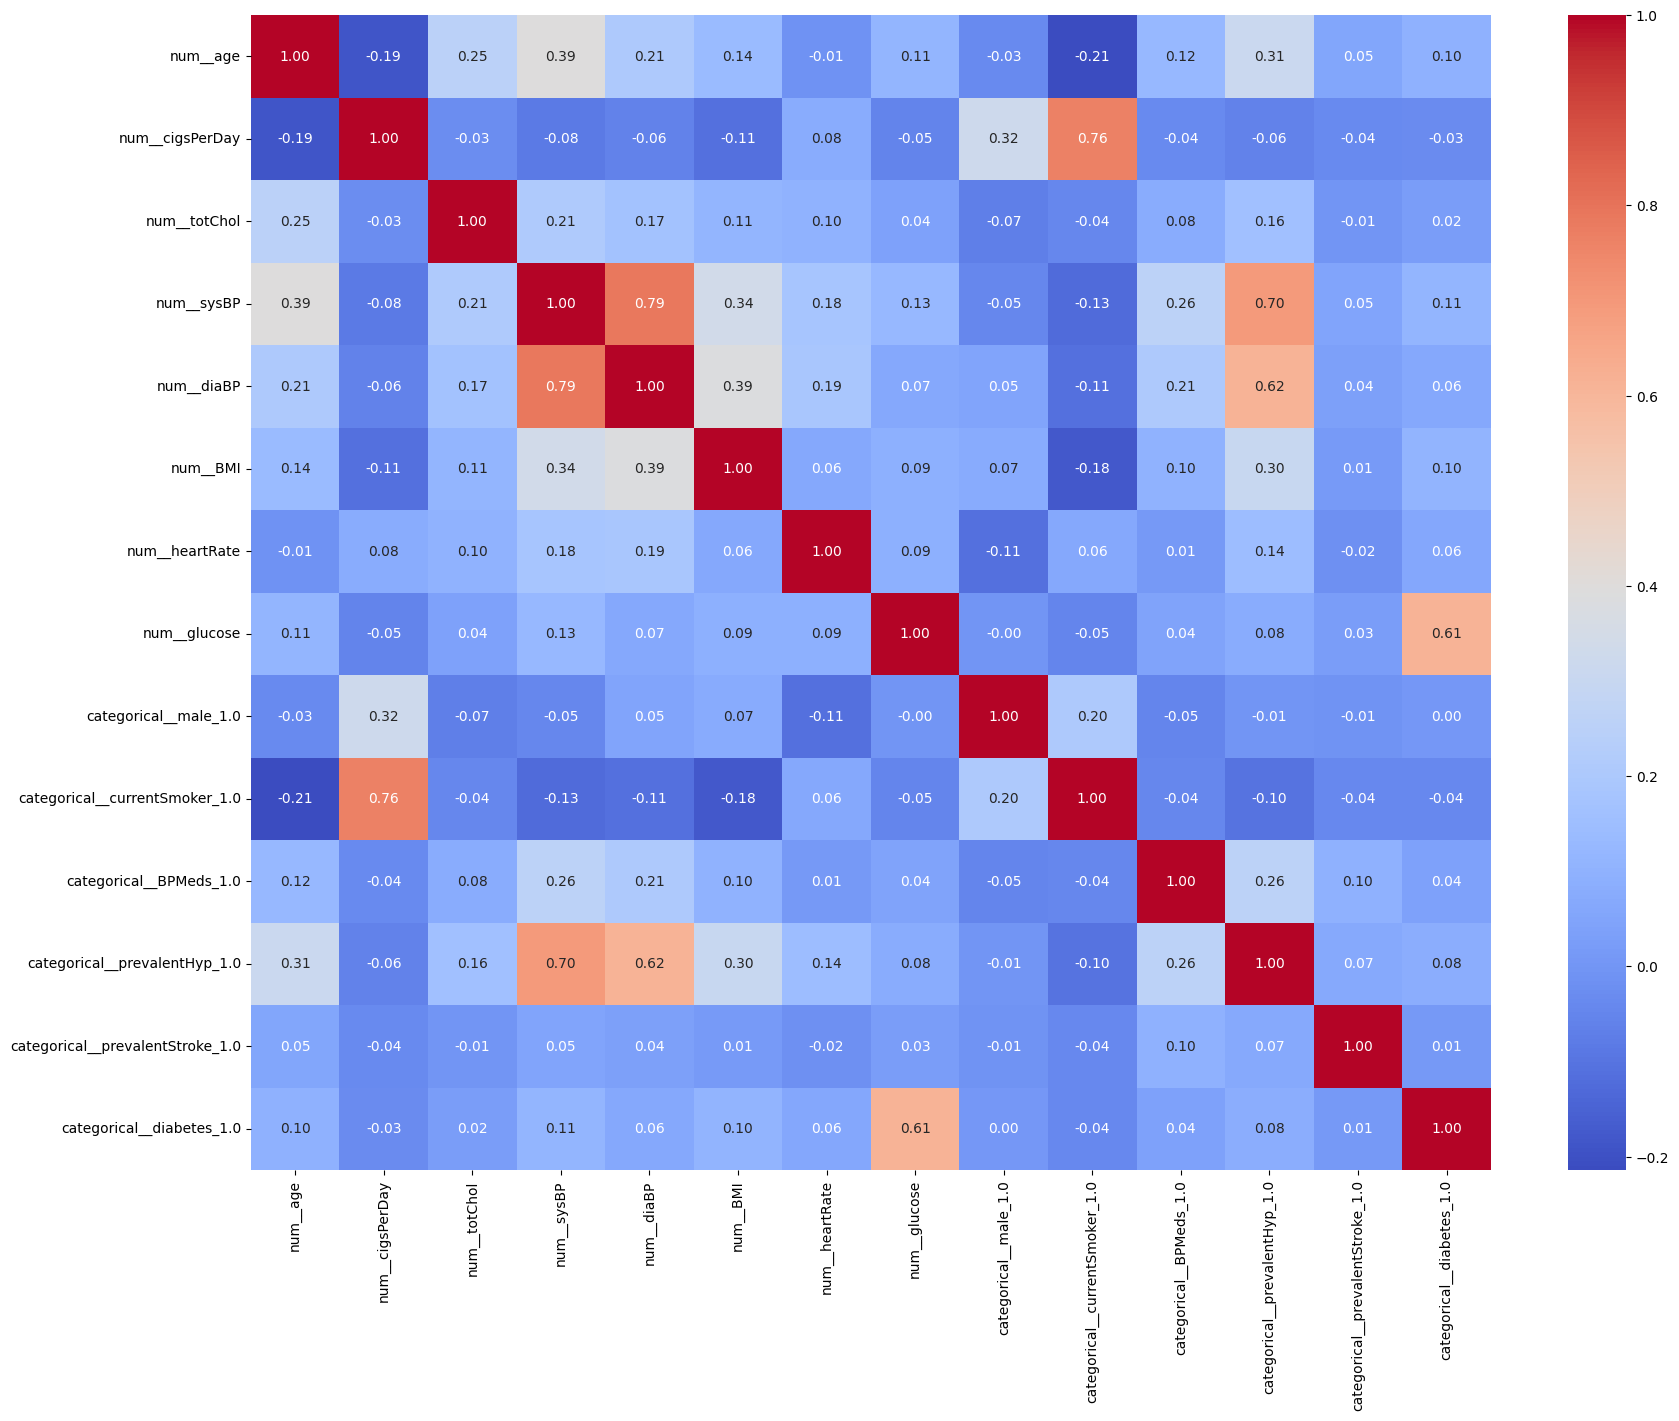

In [373]:
fig, ax = plt.subplots(figsize = (20, 15))
sns.heatmap(corr_mat, annot=True, fmt = '.2f', cmap = 'coolwarm', ax = ax)
plt.show()

From the above figure, it can be observed that,

1. The columns categorical__currentSmoker_1.0 and num__cigsPerDay are highly correlated

2. The columns categorical__prevalentHyp_1.0 and num__sysBP are highly correlated

3. The columns categorical__prevalentHyp_1.0 and num__diaBP are moderately correlated

4. The columns categorical__diabetes_1.0 and num__glucose are moderately correlated

5. The columns num__diaBP and num__sysBP are highly correlated

We'll cross verify the results by using VIF method as well

In [374]:
vif_df = pd.DataFrame()
vif_df['feature'] = X_train_df.columns
vif_df['vif'] = [variance_inflation_factor(X_train_df.values, i) for i in range(X_train_df.shape[1])]

print(vif_df.sort_values(by = 'vif', ascending=False))

                             feature       vif
3                         num__sysBP  3.723005
4                         num__diaBP  2.992722
9     categorical__currentSmoker_1.0  2.554482
11     categorical__prevalentHyp_1.0  2.487132
8              categorical__male_1.0  1.694056
13         categorical__diabetes_1.0  1.643409
1                    num__cigsPerDay  1.641672
7                       num__glucose  1.626294
0                           num__age  1.352858
5                           num__BMI  1.230413
10           categorical__BPMeds_1.0  1.129245
2                       num__totChol  1.103231
6                     num__heartRate  1.094670
12  categorical__prevalentStroke_1.0  1.021073


We'll proceed with the results of correlation matrix and remove one of the columns in highly strong pairwise correlated features. Once we build a model, we'll check for multicollinearity based on the combined effects of all the features using VIF again and remove those columns that result in poor R2 score.

As of now, we'll remove the columns:

1. categorical_currentSmoker_1.0

2. categorical_prevalentHyp_1.0

3. num_diaBP

In [471]:
X_train_final = X_train_df.drop(columns = ['categorical__currentSmoker_1.0', 'categorical__prevalentHyp_1.0', 'num__diaBP'], axis = 1)

X_test_final = X_test_df.drop(columns = ['categorical__currentSmoker_1.0', 'categorical__prevalentHyp_1.0', 'num__diaBP'], axis = 1)

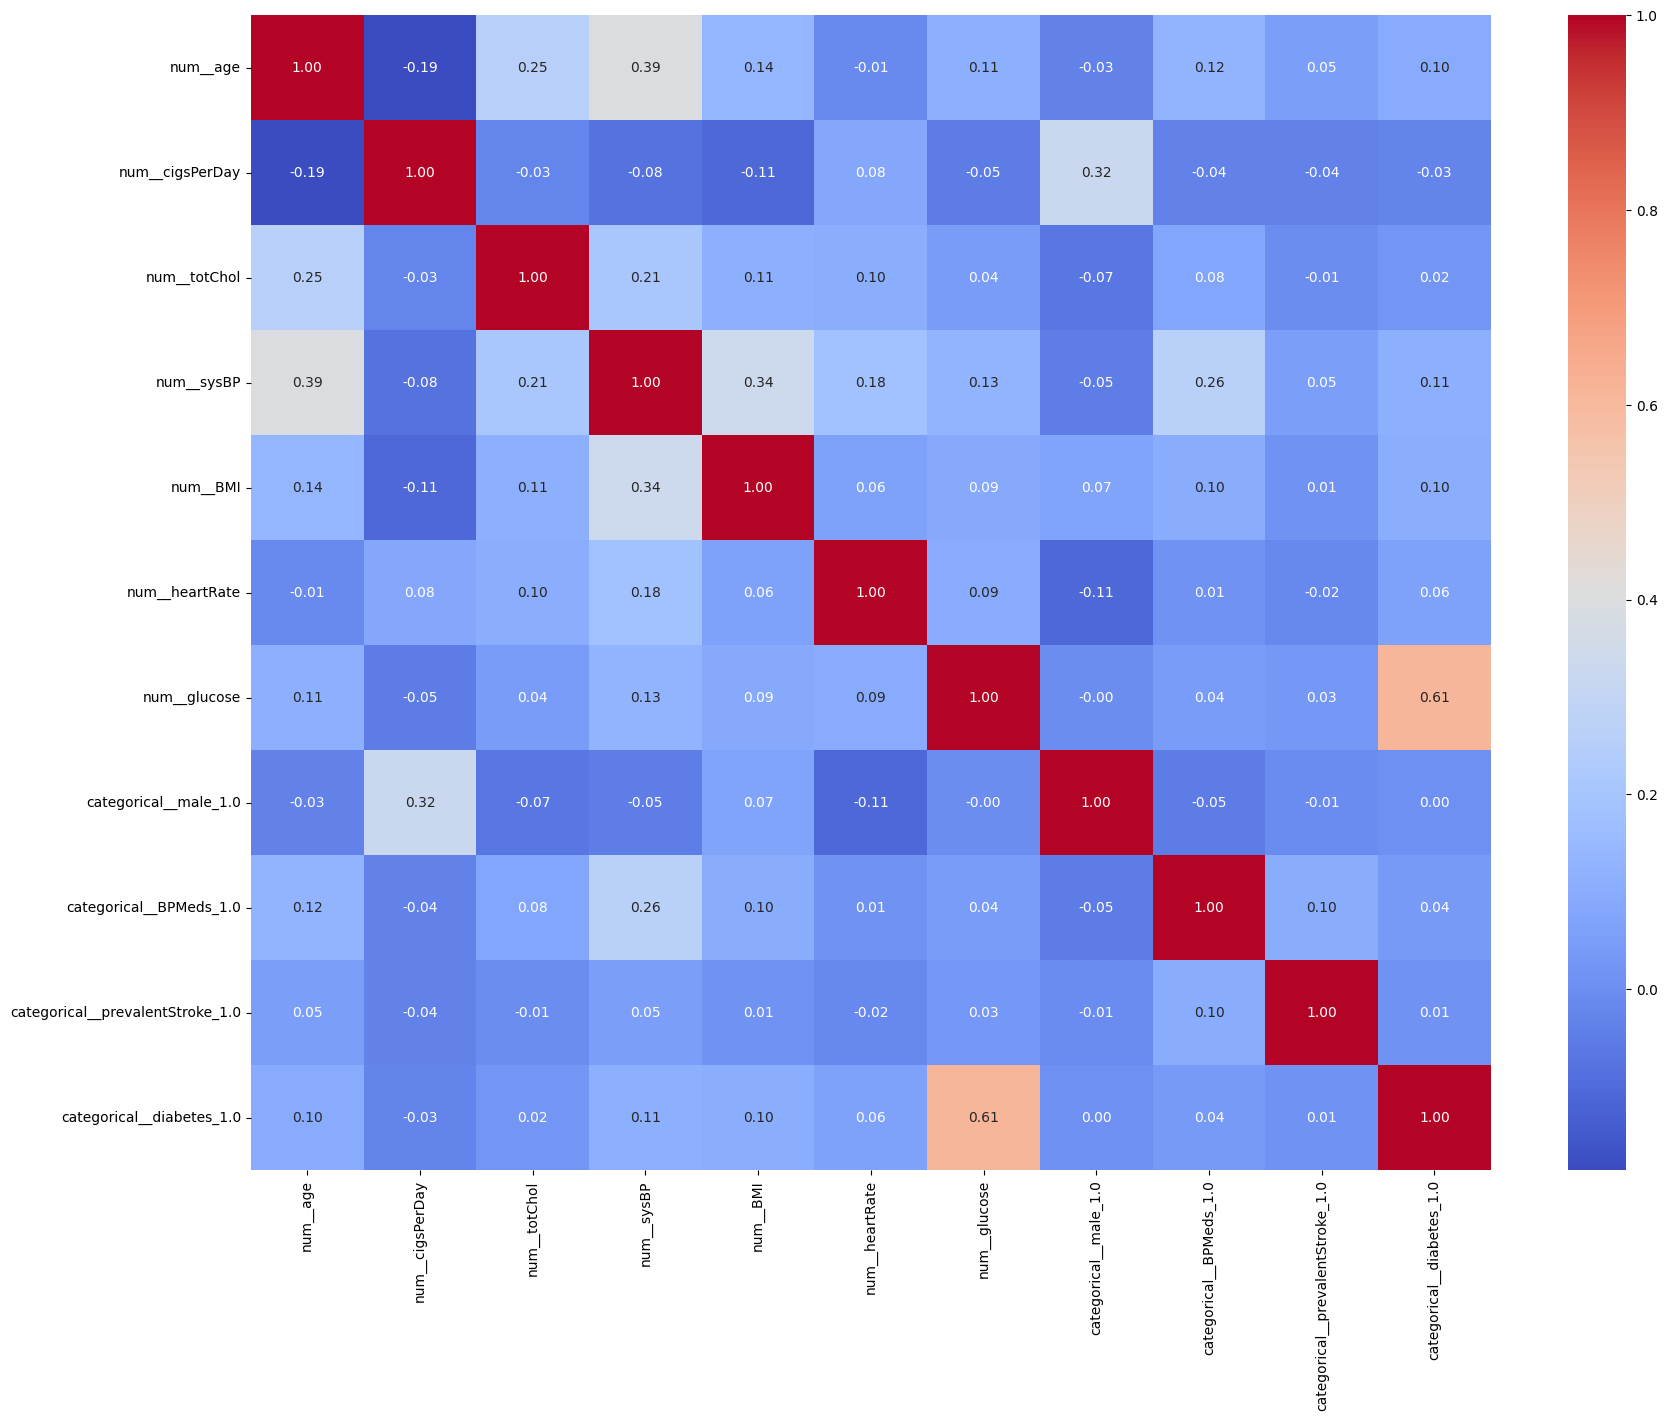

In [376]:
a = X_train_final.corr()

fig, ax = plt.subplots(figsize= (20, 15))
sns.heatmap(a, annot=True, fmt = '.2f', cmap = 'coolwarm', ax = ax)
plt.show()

From the above result map it can be seen that there are no extreme correlations present

## **Model Building**

### **Logistic Regression**

#### **Basic Logistic Regression**

In [472]:
model = LogisticRegression(max_iter = 3000)
model.fit(X_train_final, y_train)

pred = model.predict(X_test_final)

accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)
conf_mat = confusion_matrix(y_test, pred)

print(f'Accuracy is {accuracy:2f}\n')
print(f'Precision is {precision:2f}\n')
print(f'Recall is {recall:2f}\n')
print(f'F1 Score is {f1:2f}\n')
print(f'Confusion Matrix')
print(conf_mat)

Accuracy is 0.857311

Precision is 0.600000

Recall is 0.072581

F1 Score is 0.129496

Confusion Matrix
[[718   6]
 [115   9]]


In [485]:
row = {'Model': 'Basic Logistic Regression', 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
results_df = pd.DataFrame([row])

#### **Logistic Regression with balanced class weights**

In [487]:
model = LogisticRegression(class_weight = 'balanced', max_iter = 4000)
model.fit(X_train_final, y_train)

pred = model.predict(X_test_final)

accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)
conf_mat = confusion_matrix(y_test, pred)

print(f'Accuracy is {accuracy:2f}\n')
print(f'Precision is {precision:2f}\n')
print(f'Recall is {recall:2f}\n')
print(f'F1 Score is {f1:2f}\n')
print(f'Confusion Matrix')
print(conf_mat)

Accuracy is 0.645047

Precision is 0.235821

Recall is 0.637097

F1 Score is 0.344227

Confusion Matrix
[[468 256]
 [ 45  79]]


In [488]:
row = {'Model': 'Logistic Regression with Class Weight', 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)

#### **Choosing an optimal threshold for the Logistic Regression model**

In [490]:
y_prob_ = model.predict_proba(X_test_final)[:, 1] 
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_)

# Find optimal threshold based on your metric (e.g., F1-score)
optimal_threshold = thresholds[np.argmax(2 * (precisions * recalls) / (precisions + recalls))]
y_pred_adjusted = (y_prob_ >= optimal_threshold).astype(int)
print(f'Optimal threshold is {optimal_threshold}\n')

accuracy = accuracy_score(y_test, y_pred_adjusted)
precision = precision_score(y_test, y_pred_adjusted)
recall = recall_score(y_test, y_pred_adjusted)
f1 = f1_score(y_test, y_pred_adjusted)
conf_mat = confusion_matrix(y_test, y_pred_adjusted)

print(f'Accuracy is {accuracy:2f}\n')
print(f'Precision is {precision:2f}\n')
print(f'Recall is {recall:2f}\n')
print(f'F1 Score is {f1:2f}\n')
print(f'Confusion Matrix')
print(conf_mat)

Optimal threshold is 0.6052284080566775

Accuracy is 0.766509

Precision is 0.313131

Recall is 0.500000

F1 Score is 0.385093

Confusion Matrix
[[588 136]
 [ 62  62]]


In [491]:
row = {'Model': 'Logistic Regression with Optimal Threshold', 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)

#### **Logistic Regression with top N features**

In [493]:
selector = SelectKBest(score_func = chi2, k = 10)

X_train_filled = X_train.fillna(X_train.mean())
X_test_filled = X_test.fillna(X_test.mean())

X_train_selected = selector.fit_transform(X_train_filled, y_train)
X_test_selected = selector.transform(X_test_filled)

print("Selected Features Indexes:", selector.get_support(indices=True))
selected_indexes = selector.get_support(indices=True)

Selected Features Indexes: [ 1  3  4  5  6  7  8  9 10 13]


In [494]:
X_train_selected_df = X_train_filled.iloc[:, selected_indexes]
X_test_selected_df = X_test_filled.iloc[:, selected_indexes]

num_cols = X_train_selected_df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X_train_selected_df.select_dtypes(include=['object']).columns

num_transformer = Pipeline(
    steps = [
        ('scaler', StandardScaler())
    ]
)

cat_transformer = Pipeline(
    steps = [   
        ('encoder', OneHotEncoder(handle_unknown='ignore', drop = 'first'))
    ]
)

processer = ColumnTransformer(
    transformers = [
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)

X_train_sel_df = processer.fit_transform(X_train_selected_df)
X_test_sel_df = processer.transform(X_test_selected_df)

In [495]:
model = LogisticRegression(class_weight = 'balanced', max_iter = 4000)
model.fit(X_train_sel_df, y_train)

pred = model.predict(X_test_sel_df)

accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)
conf_mat = confusion_matrix(y_test, pred)

print(f'Accuracy is {accuracy:2f}\n')
print(f'Precision is {precision:2f}\n')
print(f'Recall is {recall:2f}\n')
print(f'F1 Score is {f1:2f}\n')
print(f'Confusion Matrix')
print(conf_mat)

Accuracy is 0.642689

Precision is 0.232836

Recall is 0.629032

F1 Score is 0.339869

Confusion Matrix
[[467 257]
 [ 46  78]]


In [496]:
res = {'Model': 'Logistic Regression with Top N features', 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
results_df = pd.concat([results_df, pd.DataFrame([res])], ignore_index=True)

#### **Logistic Regression: Grid Search**

In [498]:
parameter_grid = {
    'C' : [0.01, 0.1, 1, 10],
    'penalty' : ['l1', 'l2'],
    'solver': ['liblinear'],
    'max_iter':[10, 50, 100, 150, 200, 250, 300],
    'tol': [0.0001, 0.001, 0.01]
}

model_gs = LogisticRegression(class_weight = 'balanced')

grid_search = GridSearchCV(estimator = model_gs, param_grid = parameter_grid, cv = 5)
grid_search.fit(X_train_final, y_train)

print(f'Best parameters are {grid_search.best_params_}')
print(f'Best Cross Validation accuracy is {grid_search.best_score_}')


y_pred_gs = grid_search.best_estimator_.predict(X_test_final)

accuracy = accuracy_score(y_test, y_pred_gs)
precision = precision_score(y_test, y_pred_gs)
recall = recall_score(y_test, y_pred_gs)
f1 = f1_score(y_test, y_pred_gs)
conf_mat = confusion_matrix(y_test, y_pred_gs)

print(f'Accuracy is {accuracy:2f}')
print(f'Precision is {precision:2f}')
print(f'Recall is {recall:2f}')
print(f'F1 Score is {f1:2f}')

/Users/pravinkumar/Documents/MyWorkspace/HeartDiseaseClassification/virenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/pravinkumar/Documents/MyWorkspace/HeartDiseaseClassification/virenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/pravinkumar/Documents/MyWorkspace/HeartDiseaseClassification/virenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/pravinkumar/Documents/MyWorkspace/HeartDiseaseClassification/virenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/pravinkumar/Documents/MyWorkspace/HeartDiseaseClassification/

Best parameters are {'C': 1, 'max_iter': 10, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
Best Cross Validation accuracy is 0.6755162241887905
Accuracy is 0.643868
Precision is 0.235119
Recall is 0.637097
F1 Score is 0.343478


In [499]:
res = {'Model': 'Logistic Regression with Grid Search', 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
results_df = pd.concat([results_df, pd.DataFrame([res])], ignore_index=True)

#### **Logistic Regression with manual feature selection and feature engineering**

In [384]:
data_df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [501]:
df_new = data_df.__deepcopy__()

def adjusted_hypertension(row):
    if row['prevalentHyp'] == 1 and row['sysBP'] <= 120:
        return 'Controlled'
    elif row['prevalentHyp'] == 1 and row['sysBP'] > 120:
        return 'Uncontrolled'
    elif row['prevalentHyp'] == 0 and row['sysBP'] > 140:
        return 'PotentialRisk'
    else:
        return 'NoRisk'

df_new['AdjustedHypertension'] = df_new.apply(adjusted_hypertension, axis=1)

df_new['AdjustedHypertension'] = df_new['AdjustedHypertension'].map({
    'NoRisk' : 4,
    'Controlled': 3,
    'Uncontrolled': 2,
    'PotentialRisk': 1
})

df_new['PulsePressure'] = df_new['sysBP'] - df_new['diaBP']

df = df_new[['age', 'AdjustedHypertension', 'totChol', 'PulsePressure', 'BMI', 'heartRate', 'glucose', 'TenYearCHD']]

print(f'Shape of the final dataframe used is {df.shape}\n')

Shape of the final dataframe used is (4238, 8)



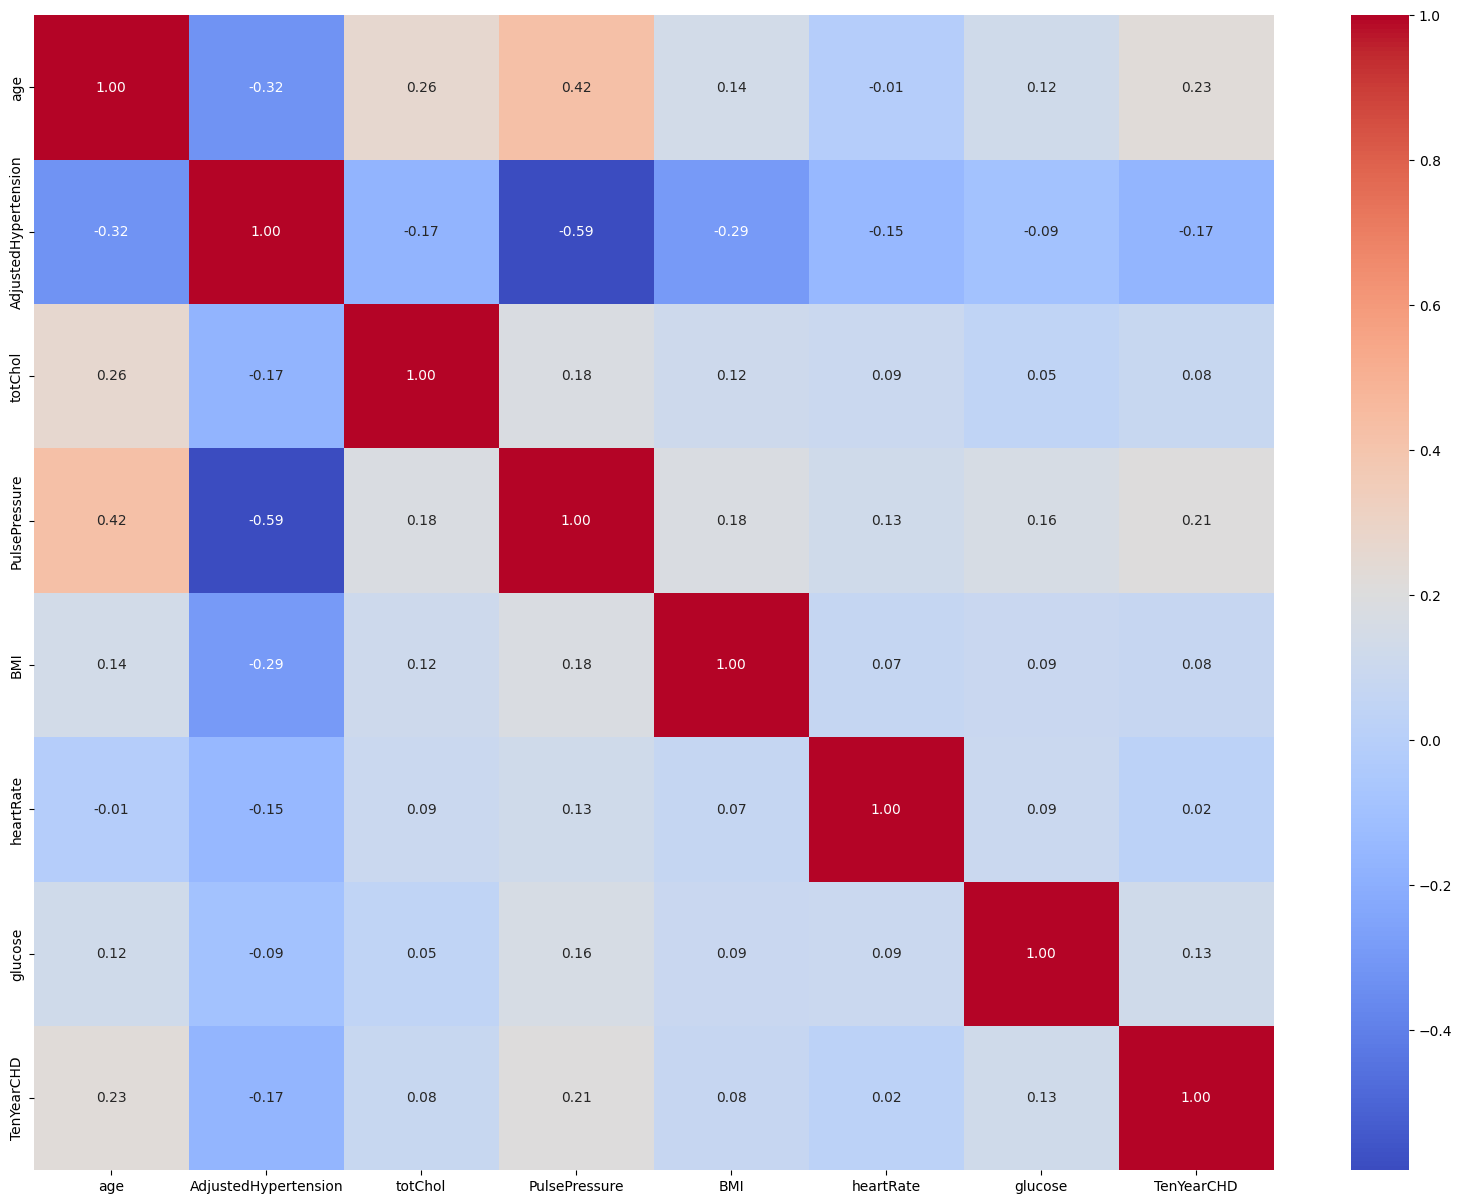

In [426]:
fig, ax = plt.subplots(figsize = (20, 15))
sns.heatmap(df.corr(), annot = True, fmt = '.2f', cmap = 'coolwarm', ax = ax)
plt.show()

In [502]:
X_train = df.drop('TenYearCHD', axis = 1)
y_train = df.loc[:,'TenYearCHD']

X_train, y_train = shuffle(X_train, y_train, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.1, random_state = 40)

numeric_features = X_train.select_dtypes(include = ['float64', 'int64']).columns
cat_features = X_train.select_dtypes(include=['object', 'category', 'bool']).columns

num_pipe = Pipeline(
    steps = [
        ('imp', SimpleImputer(strategy = 'mean')),
        ('scaler', StandardScaler())
    ]
)

cat_pipe = Pipeline(
    steps = [
        ('imp_cat', SimpleImputer(strategy = 'most_frequent')),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'))
    ]
)

processor = ColumnTransformer(
    transformers = [
    ('num', num_pipe, numeric_features),
    ('cat', cat_pipe, cat_features)
], remainder = 'passthrough')

X_train_proc = processor.fit_transform(X_train)
X_test_proc = processor.transform(X_test)

model = LogisticRegression(class_weight = 'balanced', max_iter = 100)
model.fit(X_train_proc, y_train)

pred = model.predict(X_test_proc)

accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)
conf_mat = confusion_matrix(y_test, pred)

print(f'Accuracy is {accuracy:2f}\n')
print(f'Precision is {precision:2f}\n')
print(f'Recall is {recall:2f}\n')
print(f'F1 Score is {f1:2f}\n')
print(f'Confusion Matrix')
print(conf_mat)

Accuracy is 0.674528

Precision is 0.303571

Recall is 0.708333

F1 Score is 0.425000

Confusion Matrix
[[235 117]
 [ 21  51]]


In [503]:
row = {'Model': 'Logistic Regression with Feature Engineering and Feature Selection', 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)

#### **Logistic Regression using SMOTE**

**SMOTE:** Synthetic Minority Over-sampling Technique.

This technique helps to balance the dataset by synthetically over sampling the minority class.

In [505]:
smote = SMOTE(random_state = 42)
X_train_res, y_train_res = smote.fit_resample(X_train_proc, y_train)

print(f'Original dataset shape: {X_train_proc.shape}, {y_train.shape}\n')
print(f'Resampled dataset shape: {X_train_res.shape}, {y_train_res.shape}\n') 


model_smote = LogisticRegression()
model_smote.fit(X_train_res, y_train_res)

pred_smote = model_smote.predict(X_test_proc)

accuracy = accuracy_score(y_test, pred_smote)
precision = precision_score(y_test, pred_smote)
recall = recall_score(y_test, pred_smote)
f1 = f1_score(y_test, pred_smote)
conf_mat = confusion_matrix(y_test, pred_smote)

print(f'Accuracy is {accuracy:2f}\n')
print(f'Precision is {precision:2f}\n')
print(f'Recall is {recall:2f}\n')
print(f'F1 Score is {f1:2f}\n')
print(f'Confusion Matrix')
print(conf_mat)

Original dataset shape: (3814, 7), (3814,)

Resampled dataset shape: (6484, 7), (6484,)

Accuracy is 0.672170

Precision is 0.299401

Recall is 0.694444

F1 Score is 0.418410

Confusion Matrix
[[235 117]
 [ 22  50]]


In [506]:
row = {'Model': 'Logistic Regression with SMOTE', 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)

### **SVM**

In [508]:
df2 = df_new[['age', 'AdjustedHypertension', 'totChol', 'PulsePressure', 'BMI', 'heartRate', 'glucose', 'TenYearCHD']]

In [509]:
X_train = df2.drop('TenYearCHD', axis = 1)
y_train = df2.loc[:,'TenYearCHD']

X_train, y_train = shuffle(X_train, y_train, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.1, random_state = 40)

numeric_features = X_train.select_dtypes(include = ['float64', 'int64']).columns
cat_features = X_train.select_dtypes(include=['object', 'category', 'bool']).columns

num_pipe = Pipeline(
    steps = [
        ('imp', SimpleImputer(strategy = 'mean')),
        ('scaler', StandardScaler())
    ]
)

cat_pipe = Pipeline(
    steps = [
        ('imp_cat', SimpleImputer(strategy = 'most_frequent')),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'))
    ]
)

processor = ColumnTransformer(
    transformers = [
    ('num', num_pipe, numeric_features),
    ('cat', cat_pipe, cat_features)
], remainder = 'passthrough')

X_train_proc = processor.fit_transform(X_train)
X_test_proc = processor.transform(X_test)

In [510]:
model_svc = SVC(class_weight='balanced', probability=True, kernel = 'rbf', random_state=52)
model_svc.fit(X_train_proc, y_train)

pred_svc = model_svc.predict(X_test_proc)

accuracy = accuracy_score(y_test, pred_svc)
precision = precision_score(y_test, pred_svc)
recall = recall_score(y_test, pred_svc)
f1 = f1_score(y_test, pred_svc)
conf_mat = confusion_matrix(y_test, pred_svc)

print(f'Accuracy is {accuracy:2f}\n')
print(f'Precision is {precision:2f}\n')
print(f'Recall is {recall:2f}\n')
print(f'F1 Score is {f1:2f}\n')
print(f'Confusion Matrix')
print(conf_mat)

Accuracy is 0.662736

Precision is 0.297143

Recall is 0.722222

F1 Score is 0.421053

Confusion Matrix
[[229 123]
 [ 20  52]]


In [511]:
row = {'Model': 'Support Vector Classifier', 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)

### **K-NN**

In [513]:
model_knn = KNeighborsClassifier(n_neighbors = 5,  weights = 'distance', metric = 'euclidean')
model_knn.fit(X_train_proc, y_train)

pred_knn = model_knn.predict(X_test_proc)

accuracy = accuracy_score(y_test, pred_knn)
precision = precision_score(y_test, pred_knn)
recall = recall_score(y_test, pred_knn)
f1 = f1_score(y_test, pred_knn)
conf_mat = confusion_matrix(y_test, pred_knn)

print(f'Accuracy is {accuracy:2f}\n')
print(f'Precision is {precision:2f}\n')
print(f'Recall is {recall:2f}\n')
print(f'F1 Score is {f1:2f}\n')
print(f'Confusion Matrix')
print(conf_mat)

Accuracy is 0.823113

Precision is 0.428571

Recall is 0.125000

F1 Score is 0.193548

Confusion Matrix
[[340  12]
 [ 63   9]]


In [514]:
row = {'Model': 'KNN', 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)

### **XGBoost Classifier**

In [516]:
X = df_new.drop('TenYearCHD', axis = 1)
y = df_new['TenYearCHD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=40)

model_xgb = XGBClassifier(
    n_estimators = 100,
    learning_rate = 0.1,
    max_depth = 6,
    subsample = 0.8,
    colsample_bytree = 0.8,
    random_state = 42,
    enable_categorical = True,
    tree_method = 'hist',
    eval_metric = 'auc',
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
)

model_xgb.fit(X_train, y_train)

pred_xgb = model_xgb.predict(X_test)

accuracy = accuracy_score(y_test, pred_xgb)
precision = precision_score(y_test, pred_xgb)
recall = recall_score(y_test, pred_xgb)
f1 = f1_score(y_test, pred_xgb)
conf_mat = confusion_matrix(y_test, pred_xgb)

print(f'Accuracy is {accuracy:2f}\n')
print(f'Precision is {precision:2f}\n')
print(f'Recall is {recall:2f}\n')
print(f'F1 Score is {f1:2f}\n')
print(f'Confusion Matrix')
print(conf_mat)

Accuracy is 0.761792

Precision is 0.323529

Recall is 0.285714

F1 Score is 0.303448

Confusion Matrix
[[301  46]
 [ 55  22]]


In [517]:
row = {'Model': 'XGBoost Classifier', 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)

### **Random Forest**

In [519]:
df2 = df_new[['age', 'AdjustedHypertension', 'totChol', 'PulsePressure', 'BMI', 'heartRate', 'glucose', 'TenYearCHD']]

X_train = df2.drop('TenYearCHD', axis = 1)
y_train = df2.loc[:,'TenYearCHD']

X_train, y_train = shuffle(X_train, y_train, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.1, random_state = 40)

numeric_features = X_train.select_dtypes(include = ['float64', 'int64']).columns
cat_features = X_train.select_dtypes(include=['object', 'category', 'bool']).columns

num_pipe = Pipeline(
    steps = [
        ('imp', SimpleImputer(strategy = 'mean'))
    ]
)

cat_pipe = Pipeline(
    steps = [
        ('imp_cat', SimpleImputer(strategy = 'most_frequent')),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'))
    ]
)

processor = ColumnTransformer(
    transformers = [
    ('num', num_pipe, numeric_features),
    ('cat', cat_pipe, cat_features)
], remainder = 'passthrough')

X_train_proc = processor.fit_transform(X_train)
X_test_proc = processor.transform(X_test)

In [520]:
model_rf = RandomForestClassifier(n_estimators = 200, class_weight = 'balanced', random_state=42)
model_rf.fit(X_train_proc, y_train)

y_pred_prob = model_rf.predict_proba(X_test)[:,1]

pred_rf = [1 if prob > 0.25 else 0 for prob in y_pred_prob]

print(f'ROC AUC score {roc_auc_score(y_test, y_pred_prob)}\n')

accuracy = accuracy_score(y_test, pred_rf)
precision = precision_score(y_test, pred_rf)
recall = recall_score(y_test, pred_rf)
f1 = f1_score(y_test, pred_rf)
conf_mat = confusion_matrix(y_test, pred_rf)

print(f'Accuracy is {accuracy:2f}\n')
print(f'Precision is {precision:2f}\n')
print(f'Recall is {recall:2f}\n')
print(f'F1 Score is {f1:2f}\n')
print(f'Confusion Matrix')
print(conf_mat)

ROC AUC score 0.6888415404040404

Accuracy is 0.764151

Precision is 0.315789

Recall is 0.333333

F1 Score is 0.324324

Confusion Matrix
[[300  52]
 [ 48  24]]


/Users/pravinkumar/Documents/MyWorkspace/HeartDiseaseClassification/virenv/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [521]:
row = {'Model': 'Random Forest', 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)

## **Model Comparison**

In [527]:
table = PrettyTable()
table.field_names = results_df.columns.tolist()

for row in results_df.itertuples(index=False):
    table.add_row(row)


In [530]:
print('                                                                         ******** Results Summary ********                 \n')
print(table)

                                                                         ******** Results Summary ********                 

+--------------------------------------------------------------------+--------------------+---------------------+---------------------+---------------------+
|                               Model                                |      Accuracy      |      Precision      |        Recall       |       F1 Score      |
+--------------------------------------------------------------------+--------------------+---------------------+---------------------+---------------------+
|                     Basic Logistic Regression                      | 0.8573113207547169 |         0.6         | 0.07258064516129033 | 0.12949640287769784 |
|               Logistic Regression with Class Weight                | 0.6450471698113207 | 0.23582089552238805 |  0.6370967741935484 |  0.3442265795206972 |
|             Logistic Regression with Optimal Threshold             | 0.766509433962

The above table lists out all the models tried out and their evaluation metrics.

To best identify our model, we choose Recall as our primary metric because, Recall quantifies how much of a positive class is identified among all the positive class. Meaning we are trying to reduce the False negatives in this case.

False negatives here mean that, a person who has coronary heart disease and are classified as healthy individual. This is a high risk case as the patient might not take any preventive medications/steps which could be fatal. On the other hand, having false positives (though this is alarming and not an ideal case) that patients can undergo further checks to ensure that they don't have a heart disease meaning this doesn't lead to fatality issues as compared to the former case.

Going by the above intuition, the models, **Support Vector Classifer** and **Logistic Regression with feature engineering and feature selection** have almost **~72%** recall.

## **Future Scope**

We have achieved around 72% recall to classify an individual if he has a coronary heart disease or not. Though our Recall is decently high, our F1 score isn't that great. The max F1 score is still around 42%. 

Our future work will focus on reducing the False Positives there by increasing the Precision and hence the F1 score.

Also one thing to notice is that, the feature engineering and feature selection step lead to decent increase in Recall. Therefore focusing on additional features should also constribute postively. 

Let's meet in the updated version of this notebook.

Loading....